<a href="https://colab.research.google.com/github/D1emonk/My-repo/blob/dev/Lesson_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from tensorflow.keras import regularizers

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    random_state=42
)

X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="target")

# Объединяем X и y
new = pd.concat([X, y], axis=1)

# Сохраняем в CSV
new.to_csv("synthetic_dataset.csv", index=False)

In [3]:
# Разделение и стандартизация
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Обертка для слежения за градиентами
class GradientTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_gradients = []

    def on_train_batch_end(self, batch, logs=None):
        inputs = tf.convert_to_tensor(X_train[:64], dtype=tf.float32)
        targets = tf.convert_to_tensor(y_train[:64], dtype=tf.float32)
        targets = tf.reshape(targets, (-1, 1))  # <<< Фикс формы
        with tf.GradientTape() as tape:
            predictions = self.model(inputs, training=True)
            loss = tf.keras.losses.binary_crossentropy(targets, predictions)
        gradients = tape.gradient(loss, self.model.trainable_weights)
        flat_gradients = np.concatenate([g.numpy().flatten() for g in gradients if g is not None])
        self.epoch_gradients.append(flat_gradients)

In [5]:
# Создание модели
def build_model(activation_type):
    model = tf.keras.Sequential()
    if activation_type == "leaky_relu":
        model.add(tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    elif activation_type == "elu":
        model.add(tf.keras.layers.Dense(64, activation='elu'))
    elif activation_type == "selu":
        model.add(tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Тренировка и визуализация
activations = ['leaky_relu', 'elu', 'selu']
gradients_all = {}

for act in activations:
    print(f"\nТренировка с активацией: {act}")
    model = build_model(act)
    tracker = GradientTracker()
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0, callbacks=[tracker])
    gradients_all[act] = tracker.epoch_gradients



Тренировка с активацией: leaky_relu


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Тренировка с активацией: elu

Тренировка с активацией: selu


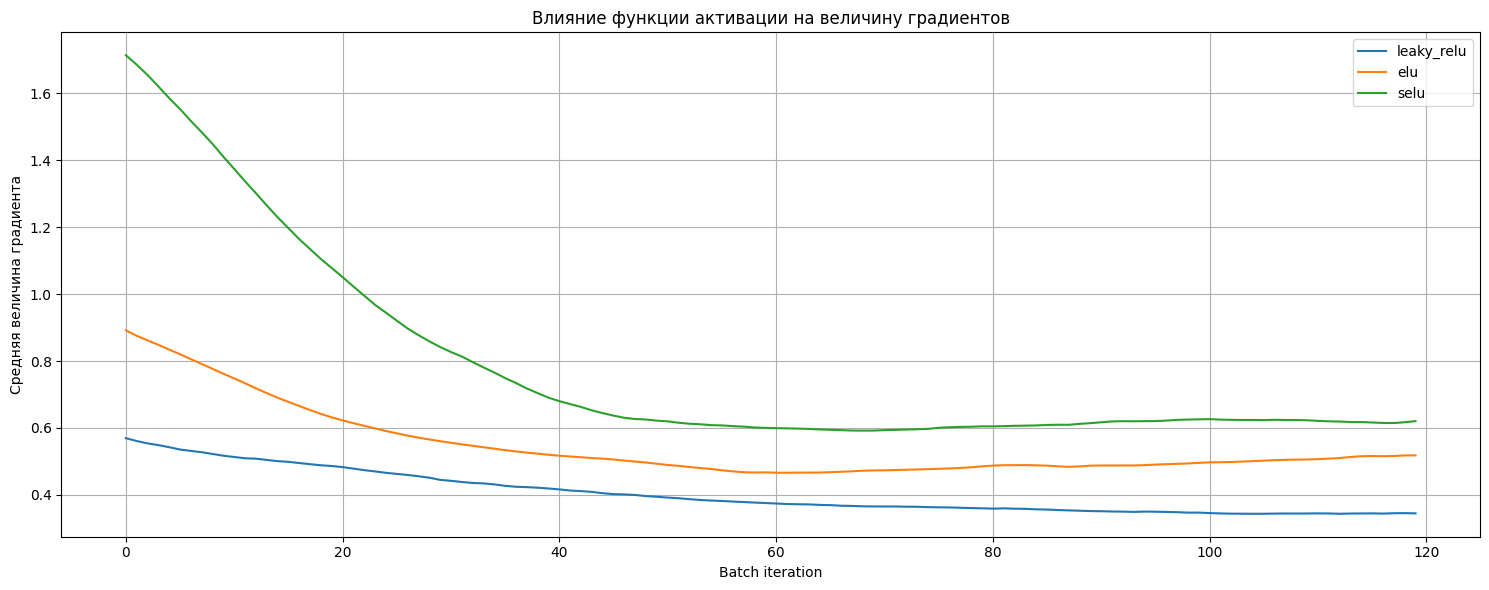

In [7]:
# Визуализация градиентов
plt.figure(figsize=(15, 6))
for act in activations:
    mean_grads = [np.mean(np.abs(g)) for g in gradients_all[act]]
    plt.plot(mean_grads, label=act)
plt.xlabel("Batch iteration")
plt.ylabel("Средняя величина градиента")
plt.title("Влияние функции активации на величину градиентов")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SELU автоматически нормализует активации, что делает обучение более стабильным, но не обязательно минимизирует градиенты. ELU демонстрирует плавное и устойчивое поведение. Leaky ReLU может сильно подавлять градиенты, особенно если коэффициент утечки (alpha) маленький. Это может замедлить обучение, но помогает избежать полностью "мертвых" нейронов.

In [8]:
def build_model_with_batchnorm(activation_type):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    if activation_type == "leaky_relu":
        model.add(tf.keras.layers.Dense(64))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

    elif activation_type == "elu":
        model.add(tf.keras.layers.Dense(64))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('elu'))

    elif activation_type == "selu":
        # Без BatchNorm и с правильной инициализацией
        model.add(tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Список активаций
activations = ["leaky_relu", "elu", "selu"]
gradient_data = {}

# Обучение моделей с отслеживанием градиентов
for act in activations:
    print(f"Обучение модели с активацией: {act}")
    model = build_model_with_batchnorm(act)
    tracker = GradientTracker()
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0, callbacks=[tracker])
    avg_grads = [np.mean(np.abs(g)) for g in tracker.epoch_gradients]
    gradient_data[act] = avg_grads

Обучение модели с активацией: leaky_relu
Обучение модели с активацией: elu
Обучение модели с активацией: selu


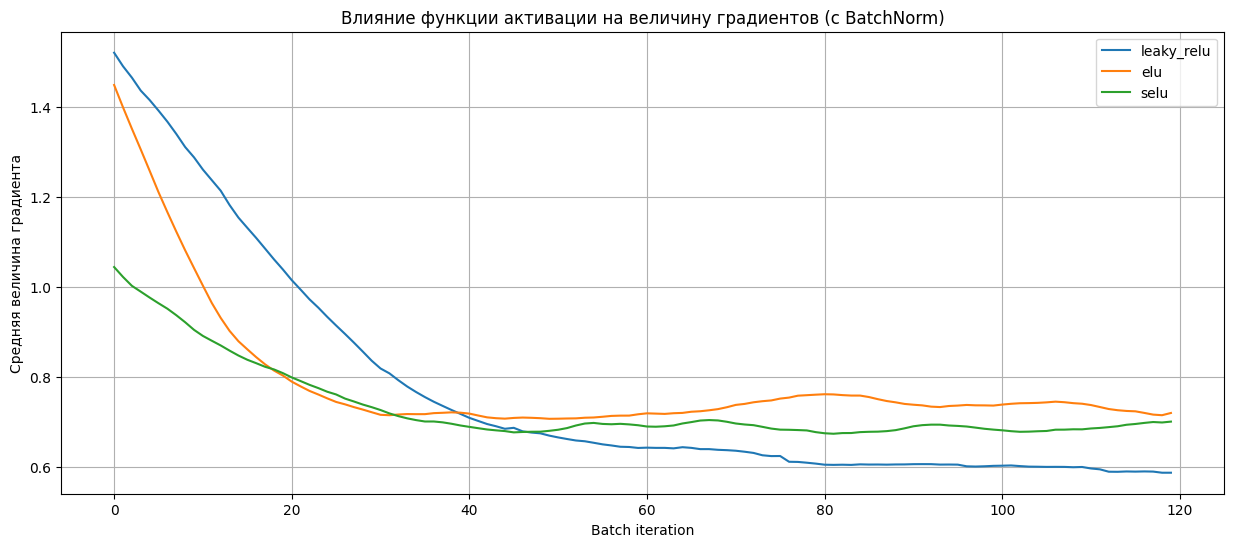

In [13]:
# Визуализация результатов
plt.figure(figsize=(15, 6))
for act in activations:
    plt.plot(gradient_data[act], label=act)
plt.title("Влияние функции активации на величину градиентов (с BatchNorm)")
plt.xlabel("Batch iteration")
plt.ylabel("Средняя величина градиента")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# SELU с AlphaDropout
def build_selu_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'),
        tf.keras.layers.AlphaDropout(0.1),
        tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'),
        tf.keras.layers.AlphaDropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Обучение моделей с отслеживанием градиентов
for act in activations:
    print(f"Обучение модели с активацией: {act}")
    if act == "selu":
        model = build_selu_model()
    else:
        model = build_model_with_batchnorm(act)
    tracker = GradientTracker()
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0, callbacks=[tracker])
    avg_grads = [np.mean(np.abs(g)) for g in tracker.epoch_gradients]
    gradient_data[act] = avg_grads

Обучение модели с активацией: leaky_relu
Обучение модели с активацией: elu
Обучение модели с активацией: selu


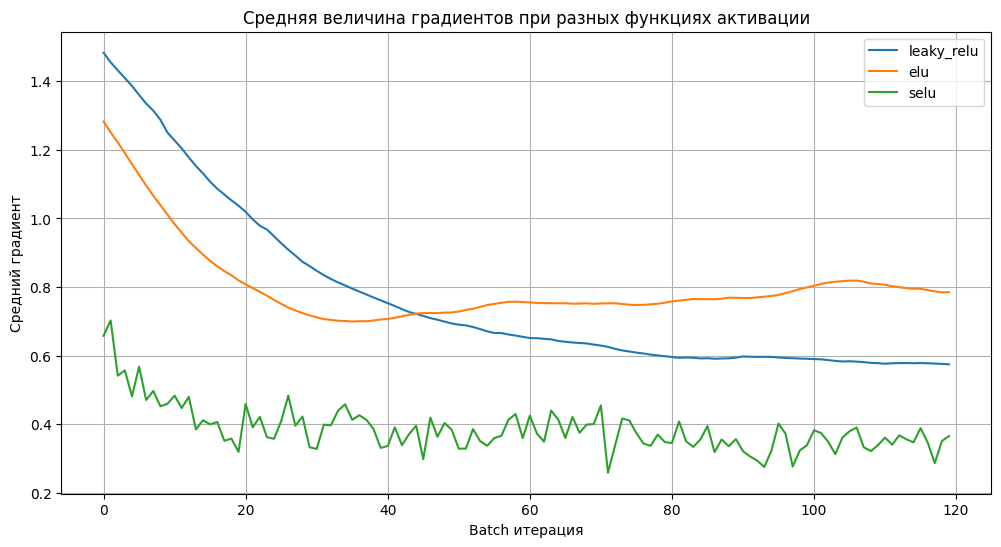

In [19]:
# График сравнения
plt.figure(figsize=(12, 6))
for act in activations:
    plt.plot(gradient_data[act], label=act)
plt.title("Средняя величина градиентов при разных функциях активации")
plt.xlabel("Batch итерация")
plt.ylabel("Средний градиент")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Глобальный регуляризатор
def get_regularizer():
    return regularizers.L1L2(l1=1e-5, l2=1e-4)

In [27]:
# LeakyReLU + BatchNorm + L1/L2
def build_leakyrelu_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, kernel_regularizer=get_regularizer()),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.1),

        tf.keras.layers.Dense(64, kernel_regularizer=get_regularizer()),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.1),

        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=get_regularizer())
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ELU + BatchNorm + L1/L2
def build_elu_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation=None, kernel_regularizer=get_regularizer()),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),

        tf.keras.layers.Dense(64, activation=None, kernel_regularizer=get_regularizer()),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),

        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=get_regularizer())
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# SELU + L1/L2
def build_selu_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal',
                              kernel_regularizer=get_regularizer()),
        tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal',
                              kernel_regularizer=get_regularizer()),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=get_regularizer())
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
activations = ["leaky_relu", "elu", "selu"]
gradient_data = {}

for act in activations:
    print(f"\nОбучение модели с активацией: {act}")
    if act == "leaky_relu":
        model = build_leakyrelu_model()
    elif act == "elu":
        model = build_elu_model()
    else:
        model = build_selu_model()

    tracker = GradientTracker()
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0, callbacks=[tracker])
    avg_grads = [np.mean(np.abs(g)) for g in tracker.epoch_gradients]
    gradient_data[act] = avg_grads


Обучение модели с активацией: leaky_relu

Обучение модели с активацией: elu

Обучение модели с активацией: selu


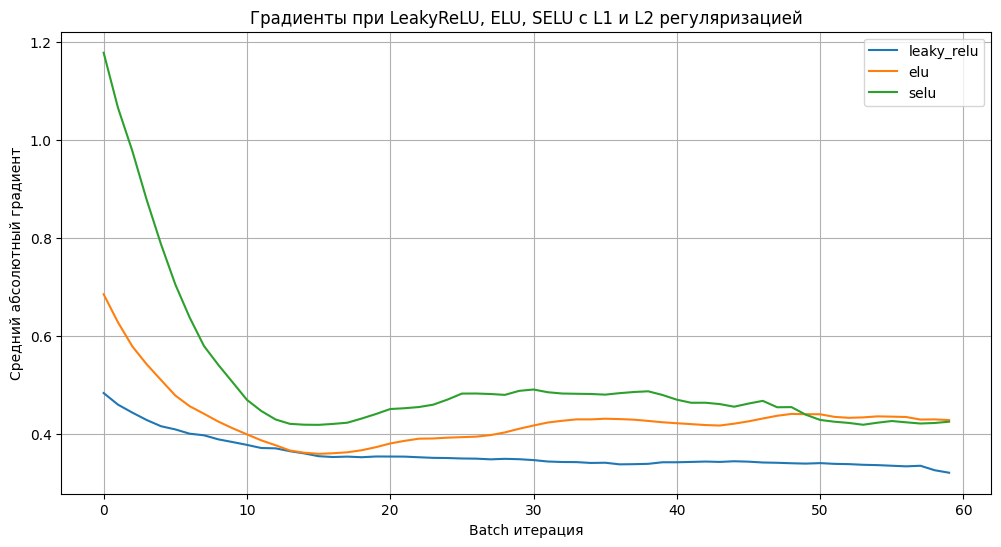

In [29]:
plt.figure(figsize=(12, 6))
for act in gradient_data:
    plt.plot(gradient_data[act], label=act)
plt.title("Градиенты при LeakyReLU, ELU, SELU с L1 и L2 регуляризацией")
plt.xlabel("Batch итерация")
plt.ylabel("Средний абсолютный градиент")
plt.legend()
plt.grid(True)
plt.show()